In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error
import sys
sys.path.insert(1, '../Merging_Data')

import WranglerFunctions as wf
import FullDataset as fd
from scipy.stats import pearsonr

In [6]:
pd.set_option('display.max_columns', None)

RIO_full = fd.GetFullDatasetForCompany("RIO LN Equity")
RIO_full.index = RIO_full['Date']
RIO_full = RIO_full.drop('Date', axis = 1)
feature_names = ["EBITDA",
    "CL1_COMB_Comodity_PX_LAST",
            "LMAHDS03_LME_Comdty_PX_LAST",
            "LMPBDS03_LME_Comdty_PX_LAST",
            "LMSNDS03_LME_Comdty_PX_LAST",
            "LMCADS03_LME_Comdty_PX_LAST",
            "LMNIDS03_LME_Comdty_PX_LAST",
            "LMCODY_LME_Comdty_PX_LAST",
            "LTBMPRIN_Index_PX_LAST",
            "Inflation_Rate",
            "Unemployment_Rate", 
            "SPX500_Index_PX_LAST",
            "SPX500_Index_PX_VOLUME",
            "F3METL_PX_LAST",
            "F3METL_PX_VOLUME",
            "GUKG10_Index_PX_LAST",
            "BCOMIN_PX_LAST",
            "UK_GDP_growth",
            "China_GDP_growth",
            "Japan_GDP_growth",
            "USA_GDP_growth",
            "Shipping_costs"]
RIO_full.set_axis(feature_names, axis = 1, inplace = True)
RIO_full

C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,EBITDA,CL1_COMB_Comodity_PX_LAST,LMAHDS03_LME_Comdty_PX_LAST,LMPBDS03_LME_Comdty_PX_LAST,LMSNDS03_LME_Comdty_PX_LAST,LMCADS03_LME_Comdty_PX_LAST,LMNIDS03_LME_Comdty_PX_LAST,LMCODY_LME_Comdty_PX_LAST,LTBMPRIN_Index_PX_LAST,Inflation_Rate,Unemployment_Rate,SPX500_Index_PX_LAST,SPX500_Index_PX_VOLUME,F3METL_PX_LAST,F3METL_PX_VOLUME,GUKG10_Index_PX_LAST,BCOMIN_PX_LAST,UK_GDP_growth,China_GDP_growth,Japan_GDP_growth,USA_GDP_growth,Shipping_costs
Date,,,,,,,,,,,,,,,,,,,,,,
2000-01-04,1404.1713,25.60,1650.0,495.5,6125.0,1169.92932,5250.27881,39125.0,100.00,1.1,5.80,1399.42,1.072386e+09,4188.60,9624338.0,5.662,80.1822,1.0,2.4,7.0,1.5,998.2346
2000-06-30,1369.7180,32.50,1580.0,449.0,5510.0,1180.81665,5310.37646,39125.0,100.00,0.8,5.60,1454.60,1.258792e+09,2323.00,9624338.0,5.171,76.2545,0.6,2.4,1.9,7.5,998.2346
2001-01-01,1628.6273,26.80,1565.0,483.0,5195.0,1223.13721,4559.14844,39125.0,100.00,0.8,5.30,1320.28,1.318392e+09,1697.10,9624338.0,4.881,74.5400,0.9,2.4,3.0,-1.3,998.2346
2001-07-02,1568.2136,26.25,1473.0,453.0,4625.0,1108.59253,4278.52930,39125.0,100.00,1.7,4.97,1236.71,1.256211e+09,1480.40,9624338.0,5.302,66.0225,0.5,2.4,-4.3,-1.6,998.2346
2001-12-31,1583.2303,19.84,1355.0,497.0,3940.0,1023.74707,3848.54346,39125.0,100.00,1.1,5.13,1148.08,1.089302e+09,1733.20,9624338.0,5.054,58.5132,0.2,2.4,-1.4,1.1,998.2346
2002-07-01,945.0000,26.86,1388.0,461.0,4460.0,1104.12988,4686.17041,39125.0,100.00,0.6,5.20,968.65,1.590400e+09,2112.30,21369987.0,5.010,63.8257,0.7,2.4,1.3,1.6,998.2346
2002-12-31,840.0000,31.20,1350.0,436.0,4280.0,968.64325,4427.19629,39125.0,100.00,1.7,5.17,879.82,1.084224e+09,656.00,2508529.0,4.374,59.2308,0.9,2.4,1.1,0.5,998.2346
2003-06-30,1178.0000,30.19,1365.0,479.0,4650.0,1001.33105,4967.32813,39125.0,100.00,1.1,5.00,974.50,1.353031e+09,2427.00,37377019.0,4.157,62.0931,0.8,2.4,2.8,3.6,998.2346
2003-12-31,1324.0000,32.52,1600.0,724.0,6525.0,1290.23218,9251.99023,39125.0,100.00,1.3,4.93,1111.92,8.362977e+08,4854.00,11824331.0,4.802,84.1474,0.8,2.4,4.4,4.7,998.2346


In [12]:
# Calculating which correlations are statistically significant
# We choose a p-value of 0.05
# Null hypothesis is if x and y are unrelated - Anything below a p-value 0.05, means that this hypothesis is rejected.

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues
pvalues = calculate_pvalues(RIO_full)
statisticallySignificant = pvalues <= 0.05
discardedColumns = statisticallySignificant[statisticallySignificant['EBITDA'].values == False].index
RIO_full = RIO_full.drop(discardedColumns, axis = 1)

In [21]:
RIO_full['Previous EBITDA'] = RIO_full['EBITDA'].shift(periods = 1)
RIO_full = RIO_full.iloc[1:]

In [14]:
f1 = np.array(RIO_full["Inflation_Rate"])        
print(f1[1:])
print(f1[:-1])
print(np.divide((f1[1:] - f1[:-1]), f1[:-1], out=np.zeros_like((f1[1:] - f1[:-1])), where=f1[:-1]!=0))

[0.8 0.8 1.7 1.1 0.6 1.7 1.1 1.3 1.6 1.7 2.  1.9 2.5 3.  2.1 3.8 3.1 1.8
 2.9 3.2 3.7 4.2 4.2 2.4 2.7 2.9 1.9 0.5 0.  0.2 0.5 1.6 2.6 3.  2.4 2.1
 2.  1.3 0.6 0.6 2.5]
[1.1 0.8 0.8 1.7 1.1 0.6 1.7 1.1 1.3 1.6 1.7 2.  1.9 2.5 3.  2.1 3.8 3.1
 1.8 2.9 3.2 3.7 4.2 4.2 2.4 2.7 2.9 1.9 0.5 0.  0.2 0.5 1.6 2.6 3.  2.4
 2.1 2.  1.3 0.6 0.6]
[-0.27272727  0.          1.125      -0.35294118 -0.45454545  1.83333333
 -0.35294118  0.18181818  0.23076923  0.0625      0.17647059 -0.05
  0.31578947  0.2        -0.3         0.80952381 -0.18421053 -0.41935484
  0.61111111  0.10344828  0.15625     0.13513514  0.         -0.42857143
  0.125       0.07407407 -0.34482759 -0.73684211 -1.          0.
  1.5         2.2         0.625       0.15384615 -0.2        -0.125
 -0.04761905 -0.35       -0.53846154  0.          3.16666667]


CL1_COMB_Comodity_PX_LAST
LMAHDS03_LME_Comdty_PX_LAST
LMPBDS03_LME_Comdty_PX_LAST
LMSNDS03_LME_Comdty_PX_LAST
LMCADS03_LME_Comdty_PX_LAST
LMNIDS03_LME_Comdty_PX_LAST
LTBMPRIN_Index_PX_LAST
Inflation_Rate
SPX500_Index_PX_LAST
SPX500_Index_PX_VOLUME
GUKG10_Index_PX_LAST
BCOMIN_PX_LAST
Shipping_costs
Previous EBITDA


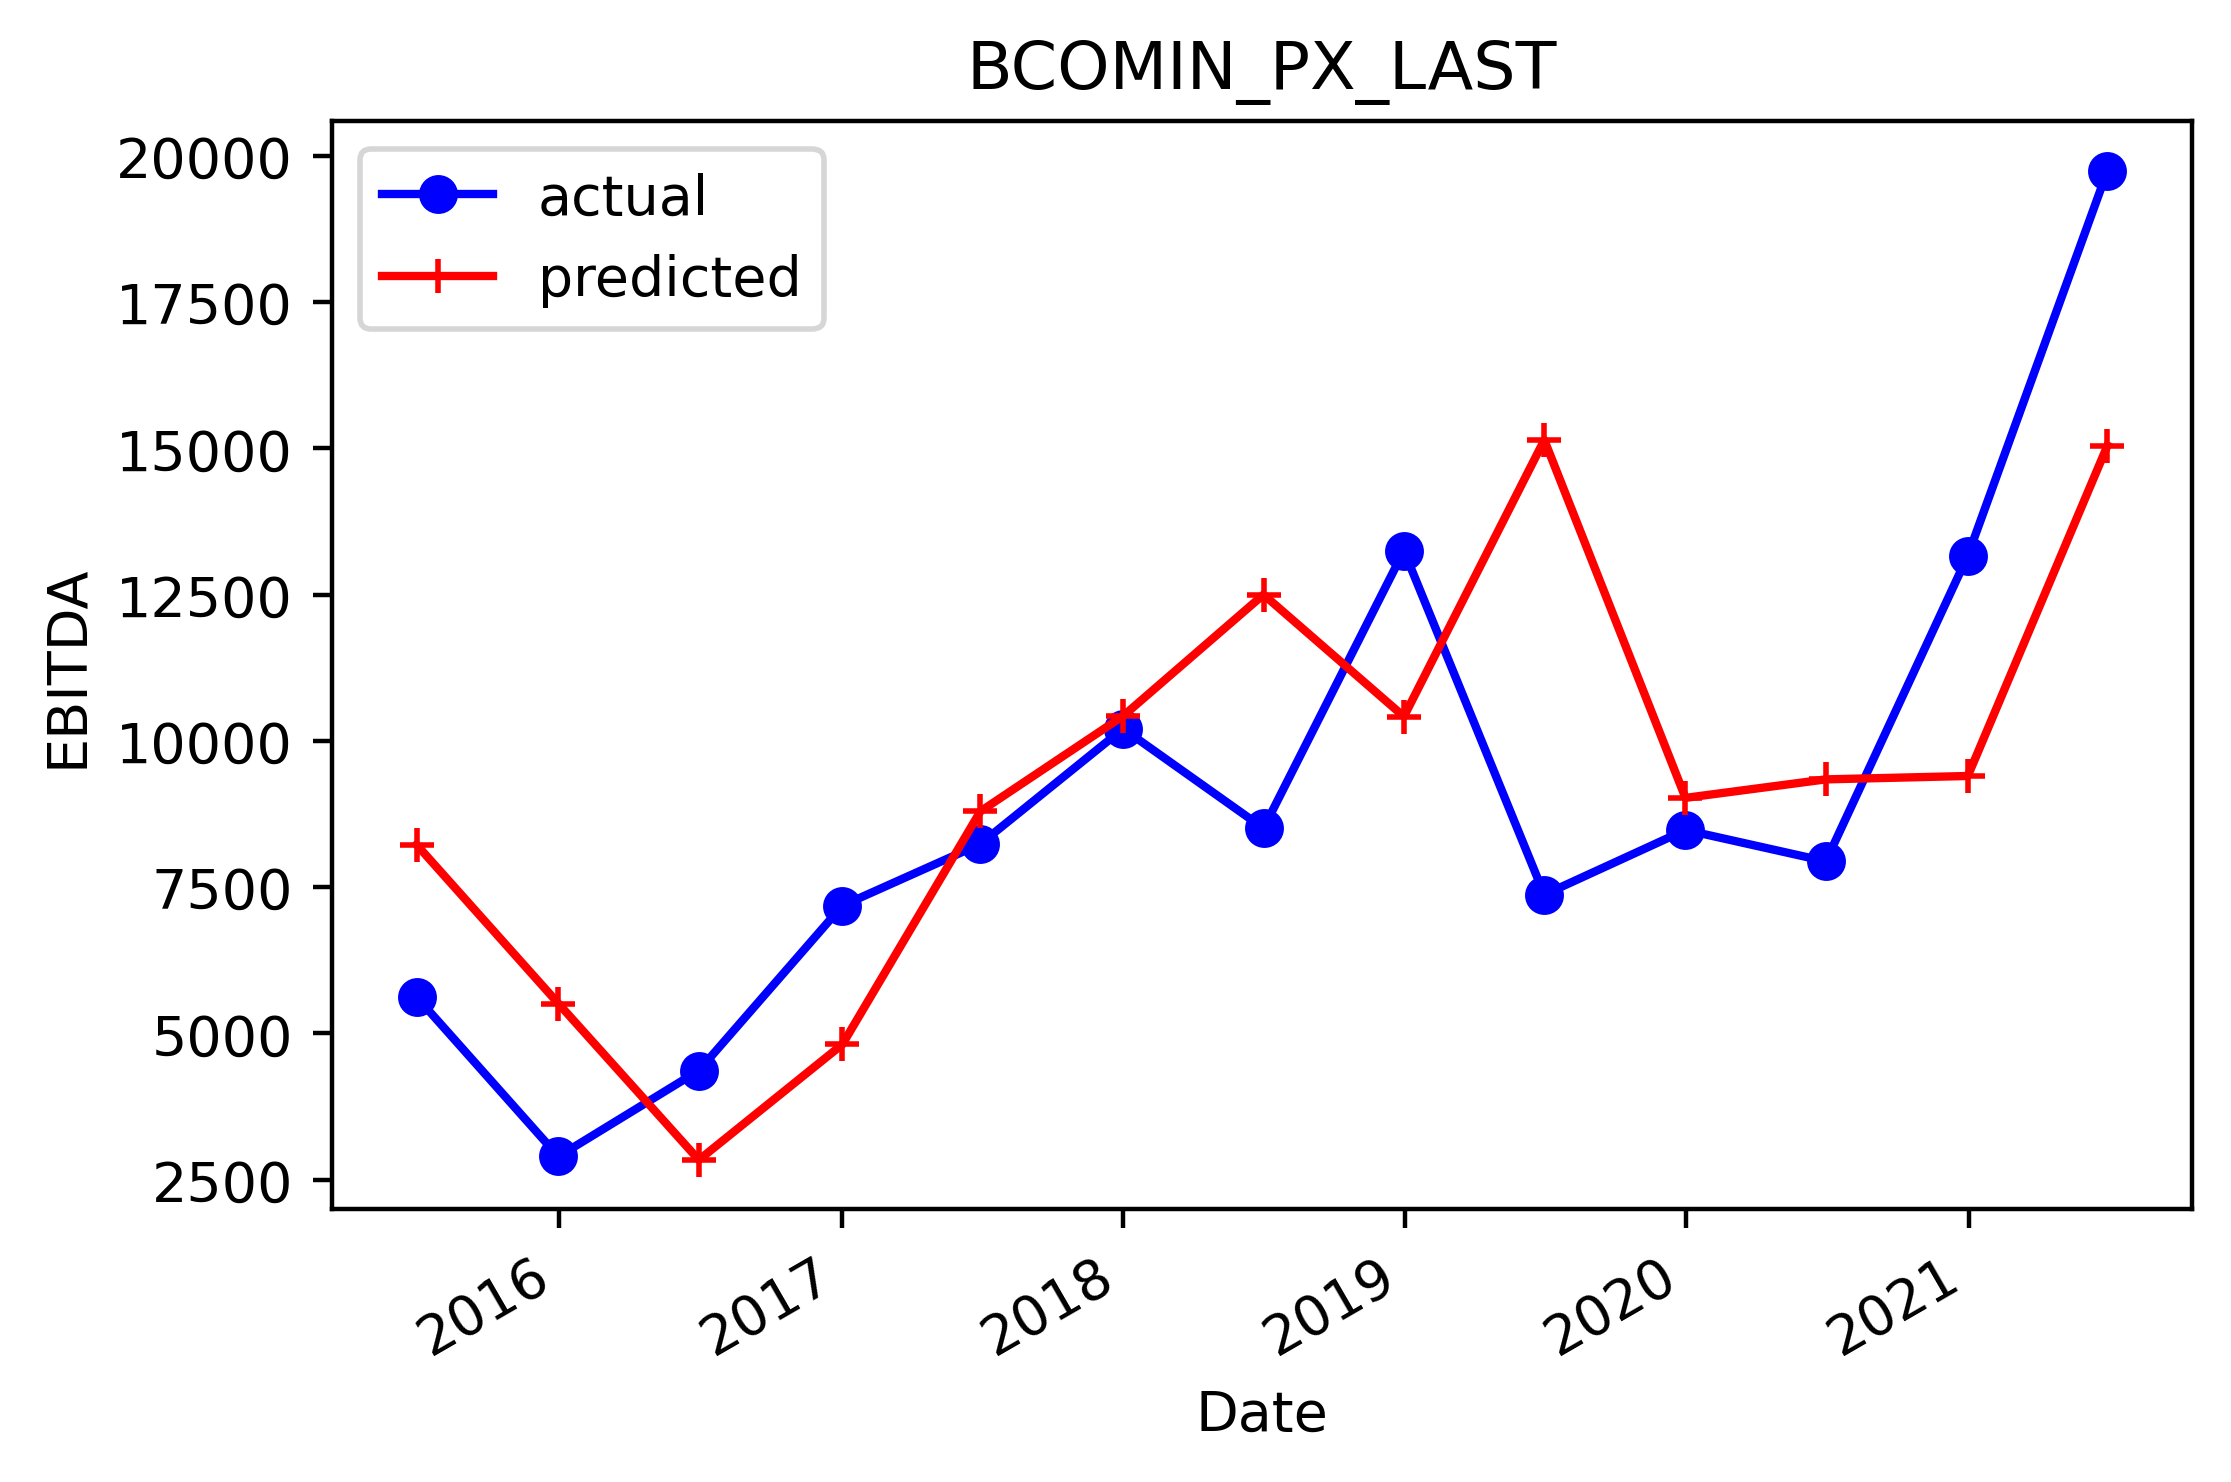

([8227.591836734693,
  5510.204081632653,
  2838.8571428571427,
  4812.612244897959,
  8796.73469387755,
  10426.122448979591,
  12500.81632653061,
  10416.73469387755,
  15144.0,
  9026.938775510203,
  9343.102040816326,
  9400.734693877552,
  15046.857142857141],
 11138869.062794348)

In [22]:
# Prediction using a Hidden Markov Model
class HMM(object):
    def __init__(self, 
                 df,
                 company_name,
                 feature_name,
                 test_size=0.3,
                 n_hidden_states=3,
                 n_latency_days=10,
                 n_steps_ebitda=50,
                 n_steps_feature=50,
                 feature_range_start=-1.0,
                 feature_range_end=1.0):
        self.n_latency_days = n_latency_days
        self.feature_name = feature_name
        self.hmm = GaussianHMM(n_components=n_hidden_states)
 
        self._split_train_test_data(df, test_size)
 
        self._compute_all_possible_outcomes(n_steps_ebitda,
            n_steps_feature, feature_range_start, feature_range_end)
 
    def _split_train_test_data(self, df, test_size):
        _train_data, _test_data = train_test_split(
            df, test_size=test_size, shuffle=False)
 
        self._train_data = _train_data
        self._test_data = _test_data
 
    @staticmethod
    def _extract_features(df, feature_name):
        ebitda = np.array(df['EBITDA'])
        feature = np.array(df[feature_name])
        feature_diff =  (feature[1:] - feature[:-1])
        frac_feature = np.divide(feature_diff, feature[:-1], out=np.zeros_like(feature_diff), where=feature[:-1]!=0)
        frac_ebitda = (ebitda[1:] - ebitda[:-1]) / ebitda[:-1]
        if feature_name in ['Inflation_Rate', 'Unemployment_Rate', 'UK_GDP_growth', 'China_GDP_growth', 'Japan_GDP_growth', 'USA_GDP_growth']:
            return np.column_stack((frac_ebitda, feature[:-1]))
        return np.column_stack((frac_ebitda, frac_feature))
 
    def fit(self):
        feature_vector = HMM._extract_features(self._train_data, self.feature_name) 
        self.hmm.fit(feature_vector)
 
    def _compute_all_possible_outcomes(self, n_steps_ebitda, n_steps_feature, feature_range_start, feature_range_end):
        frac_ebitda_range = np.linspace(-1.0, 1.0, n_steps_ebitda)
        feature_range = np.linspace(feature_range_start, feature_range_end, n_steps_feature)
        self._possible_outcomes = np.array(list(itertools.product(
            frac_ebitda_range, feature_range)))
 
    def _get_most_probable_outcome(self, feature_name, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_start_index: previous_data_end_index]
        previous_data_features = HMM._extract_features(previous_data, self.feature_name)
 
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
 
        return most_probable_outcome
 
    def predict_close_price(self, feature_name, day_index):
        previous_ebitda = self._test_data.iloc[day_index]['Previous EBITDA']
        frac_predicted_ebitda, _ = self._get_most_probable_outcome(feature_name, day_index)
        return previous_ebitda * (1 + frac_predicted_ebitda)
 
    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_ebitda = []
        for day_index in range(days):
            predicted_ebitda.append(self.predict_close_price(self.feature_name, day_index))
        test_data = self._test_data[0: days]
        days = np.array(test_data.index, dtype="datetime64[ms]")
        actual_ebitda = test_data['EBITDA']
        if with_plot:
            fig = plt.figure(dpi = 400)
            axes = fig.add_subplot(111)
            axes.plot(days, actual_ebitda, 'bo-', label="actual")
            axes.plot(days, predicted_ebitda, 'r+-', label="predicted")
            fig.autofmt_xdate()
            axes.set_title(self.feature_name)
            axes.set_ylabel('EBITDA')
            axes.set_xlabel('Date')
            plt.legend()
            plt.savefig(self.feature_name + '.png', bbox_inches='tight')
            plt.show()
        
        return predicted_ebitda, mean_squared_error(actual_ebitda, predicted_ebitda)

errors = []
models = []
company_name = "RIO LN Equity"
for feature_name in RIO_full.columns[1:]:
    print(feature_name)
    current_model = HMM(RIO_full, company_name, feature_name)
    current_model.fit()
    _, error = current_model.predict_close_prices_for_days(13, with_plot=False)
    models.append(current_model)
    errors.append(error)
    
best_model = models[np.argmin(errors)]
best_model.predict_close_prices_for_days(13, with_plot=True)
# print(len(errors))

In [36]:
for x, y in zip(RIO_full.columns[1:], errors):
    print(x, ", ", y)
# _, _ = models[0].predict_close_prices_for_days(13, with_plot=True)

CL1_COMB_Comodity_PX_LAST ,  12324409.72021273
LMAHDS03_LME_Comdty_PX_LAST ,  13507532.183929771
LMPBDS03_LME_Comdty_PX_LAST ,  12020525.57668279
LMSNDS03_LME_Comdty_PX_LAST ,  11590466.495146252
LMCADS03_LME_Comdty_PX_LAST ,  12355626.38596098
LMNIDS03_LME_Comdty_PX_LAST ,  11842293.287572484
LTBMPRIN_Index_PX_LAST ,  11747946.865120301
Inflation_Rate ,  12268714.833594978
SPX500_Index_PX_LAST ,  12734887.332489666
SPX500_Index_PX_VOLUME ,  11233001.119693717
GUKG10_Index_PX_LAST ,  15013943.419120235
BCOMIN_PX_LAST ,  11138869.062794348
Shipping_costs ,  12100007.230993496
Previous EBITDA ,  12268714.833594978
BCOMIN_PX_LAST


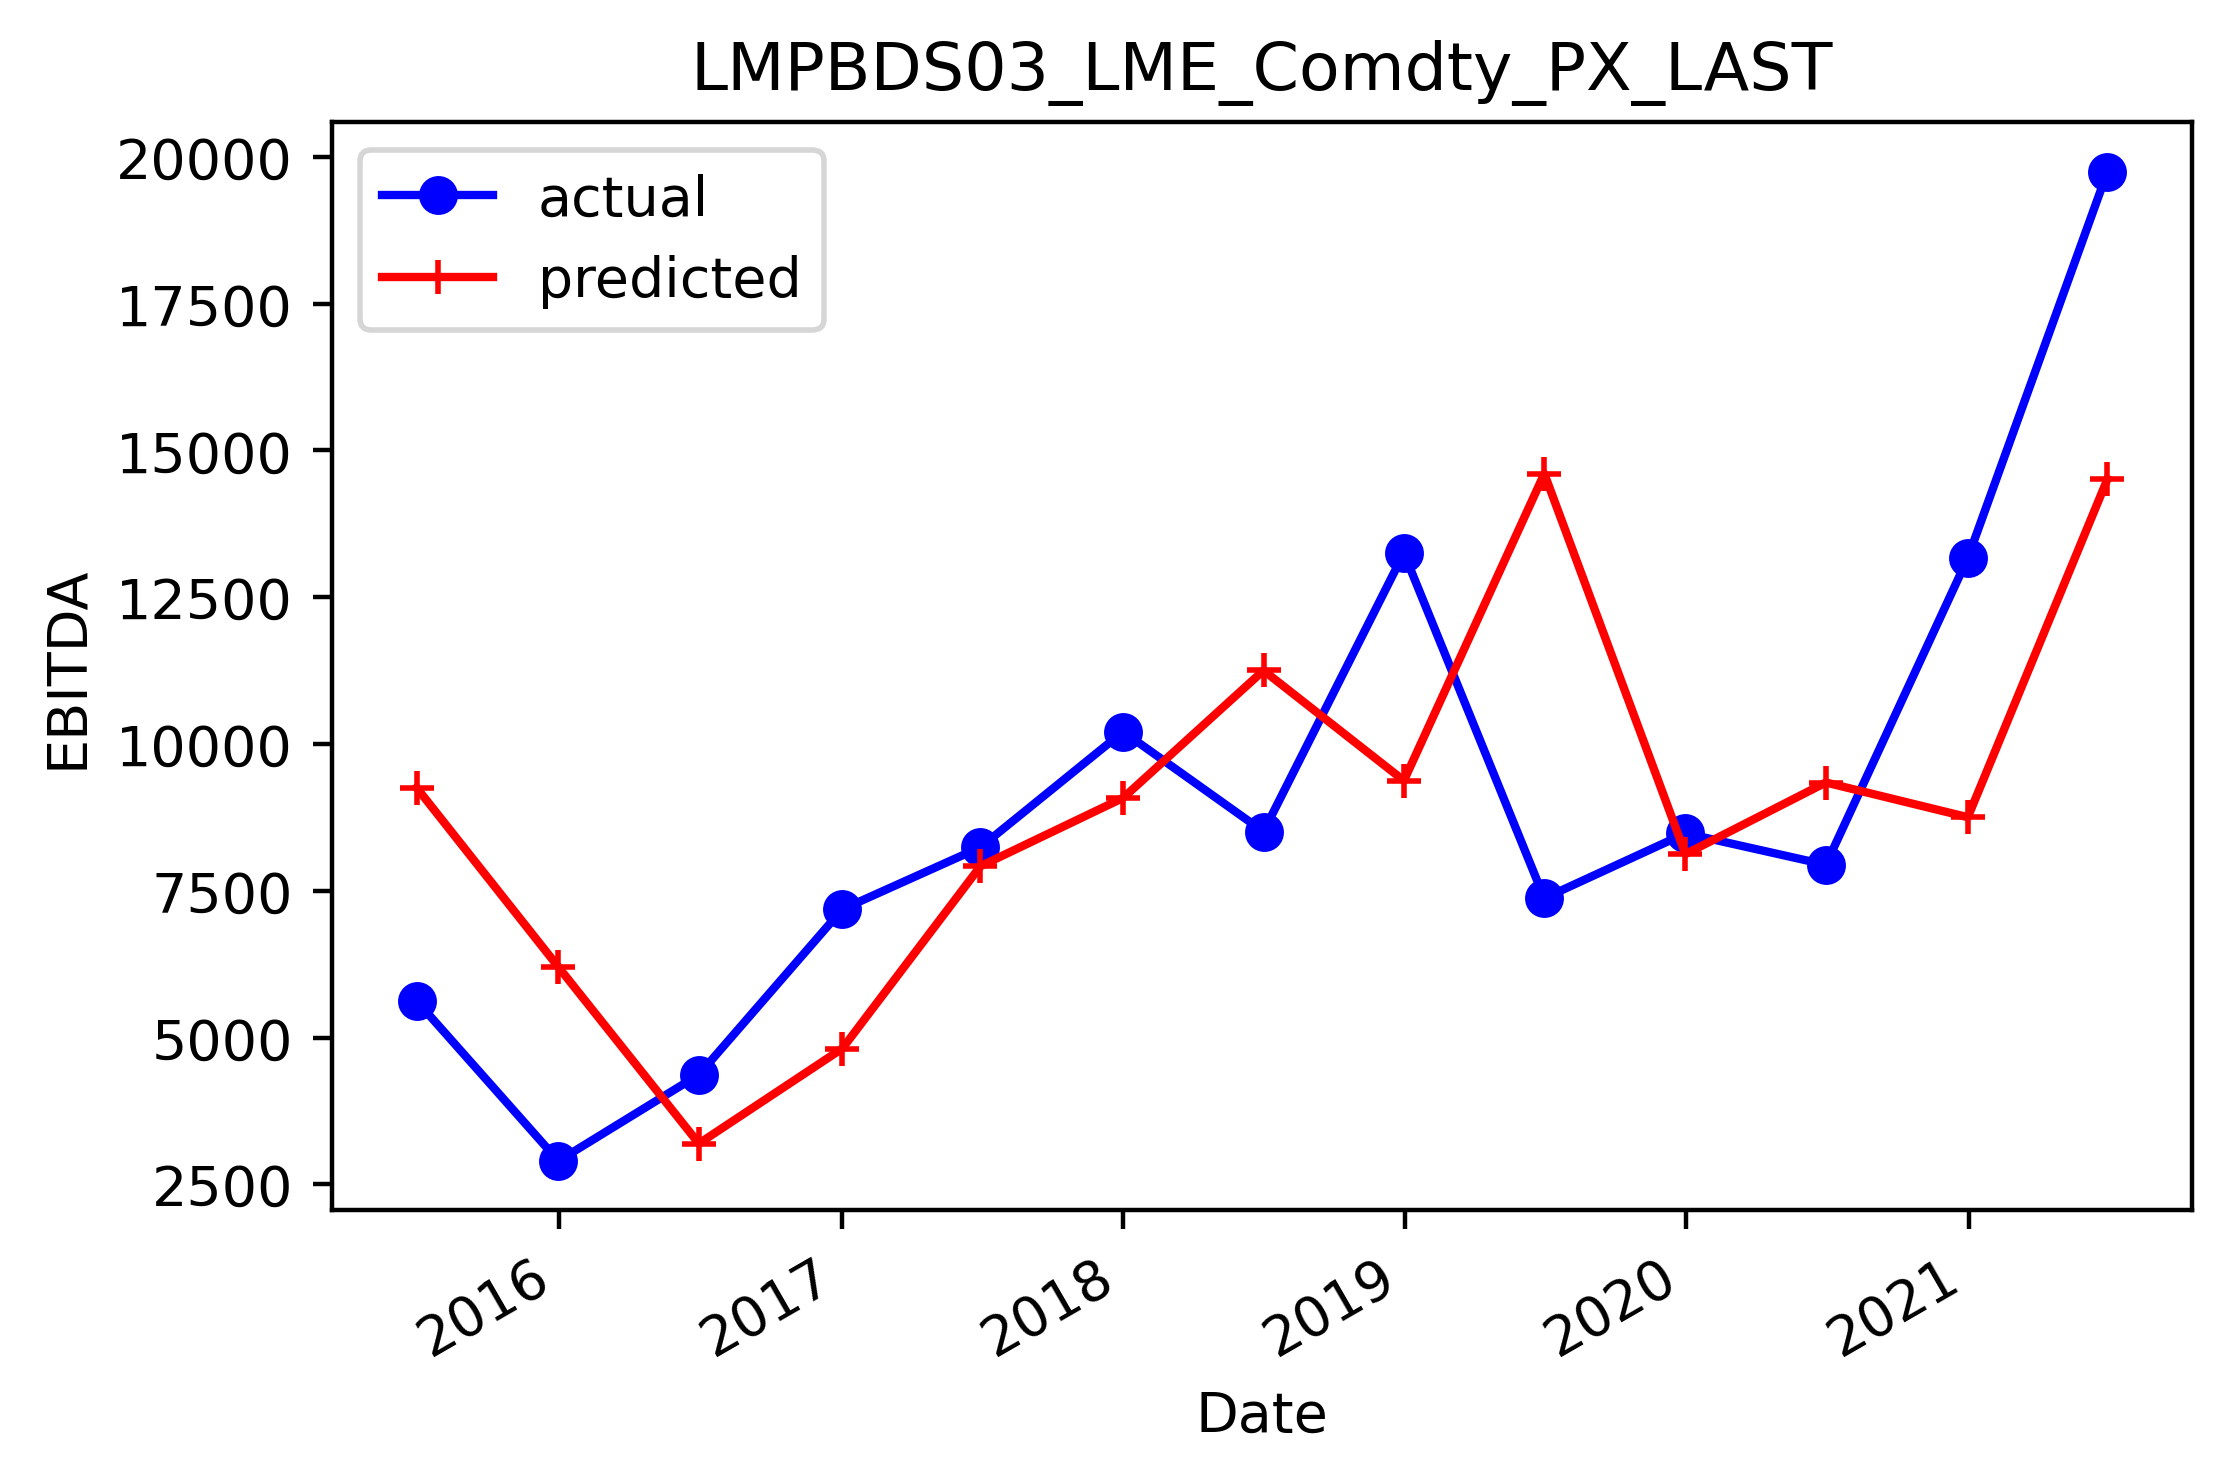

In [24]:
_, _ = models[2].predict_close_prices_for_days(13, with_plot=True)

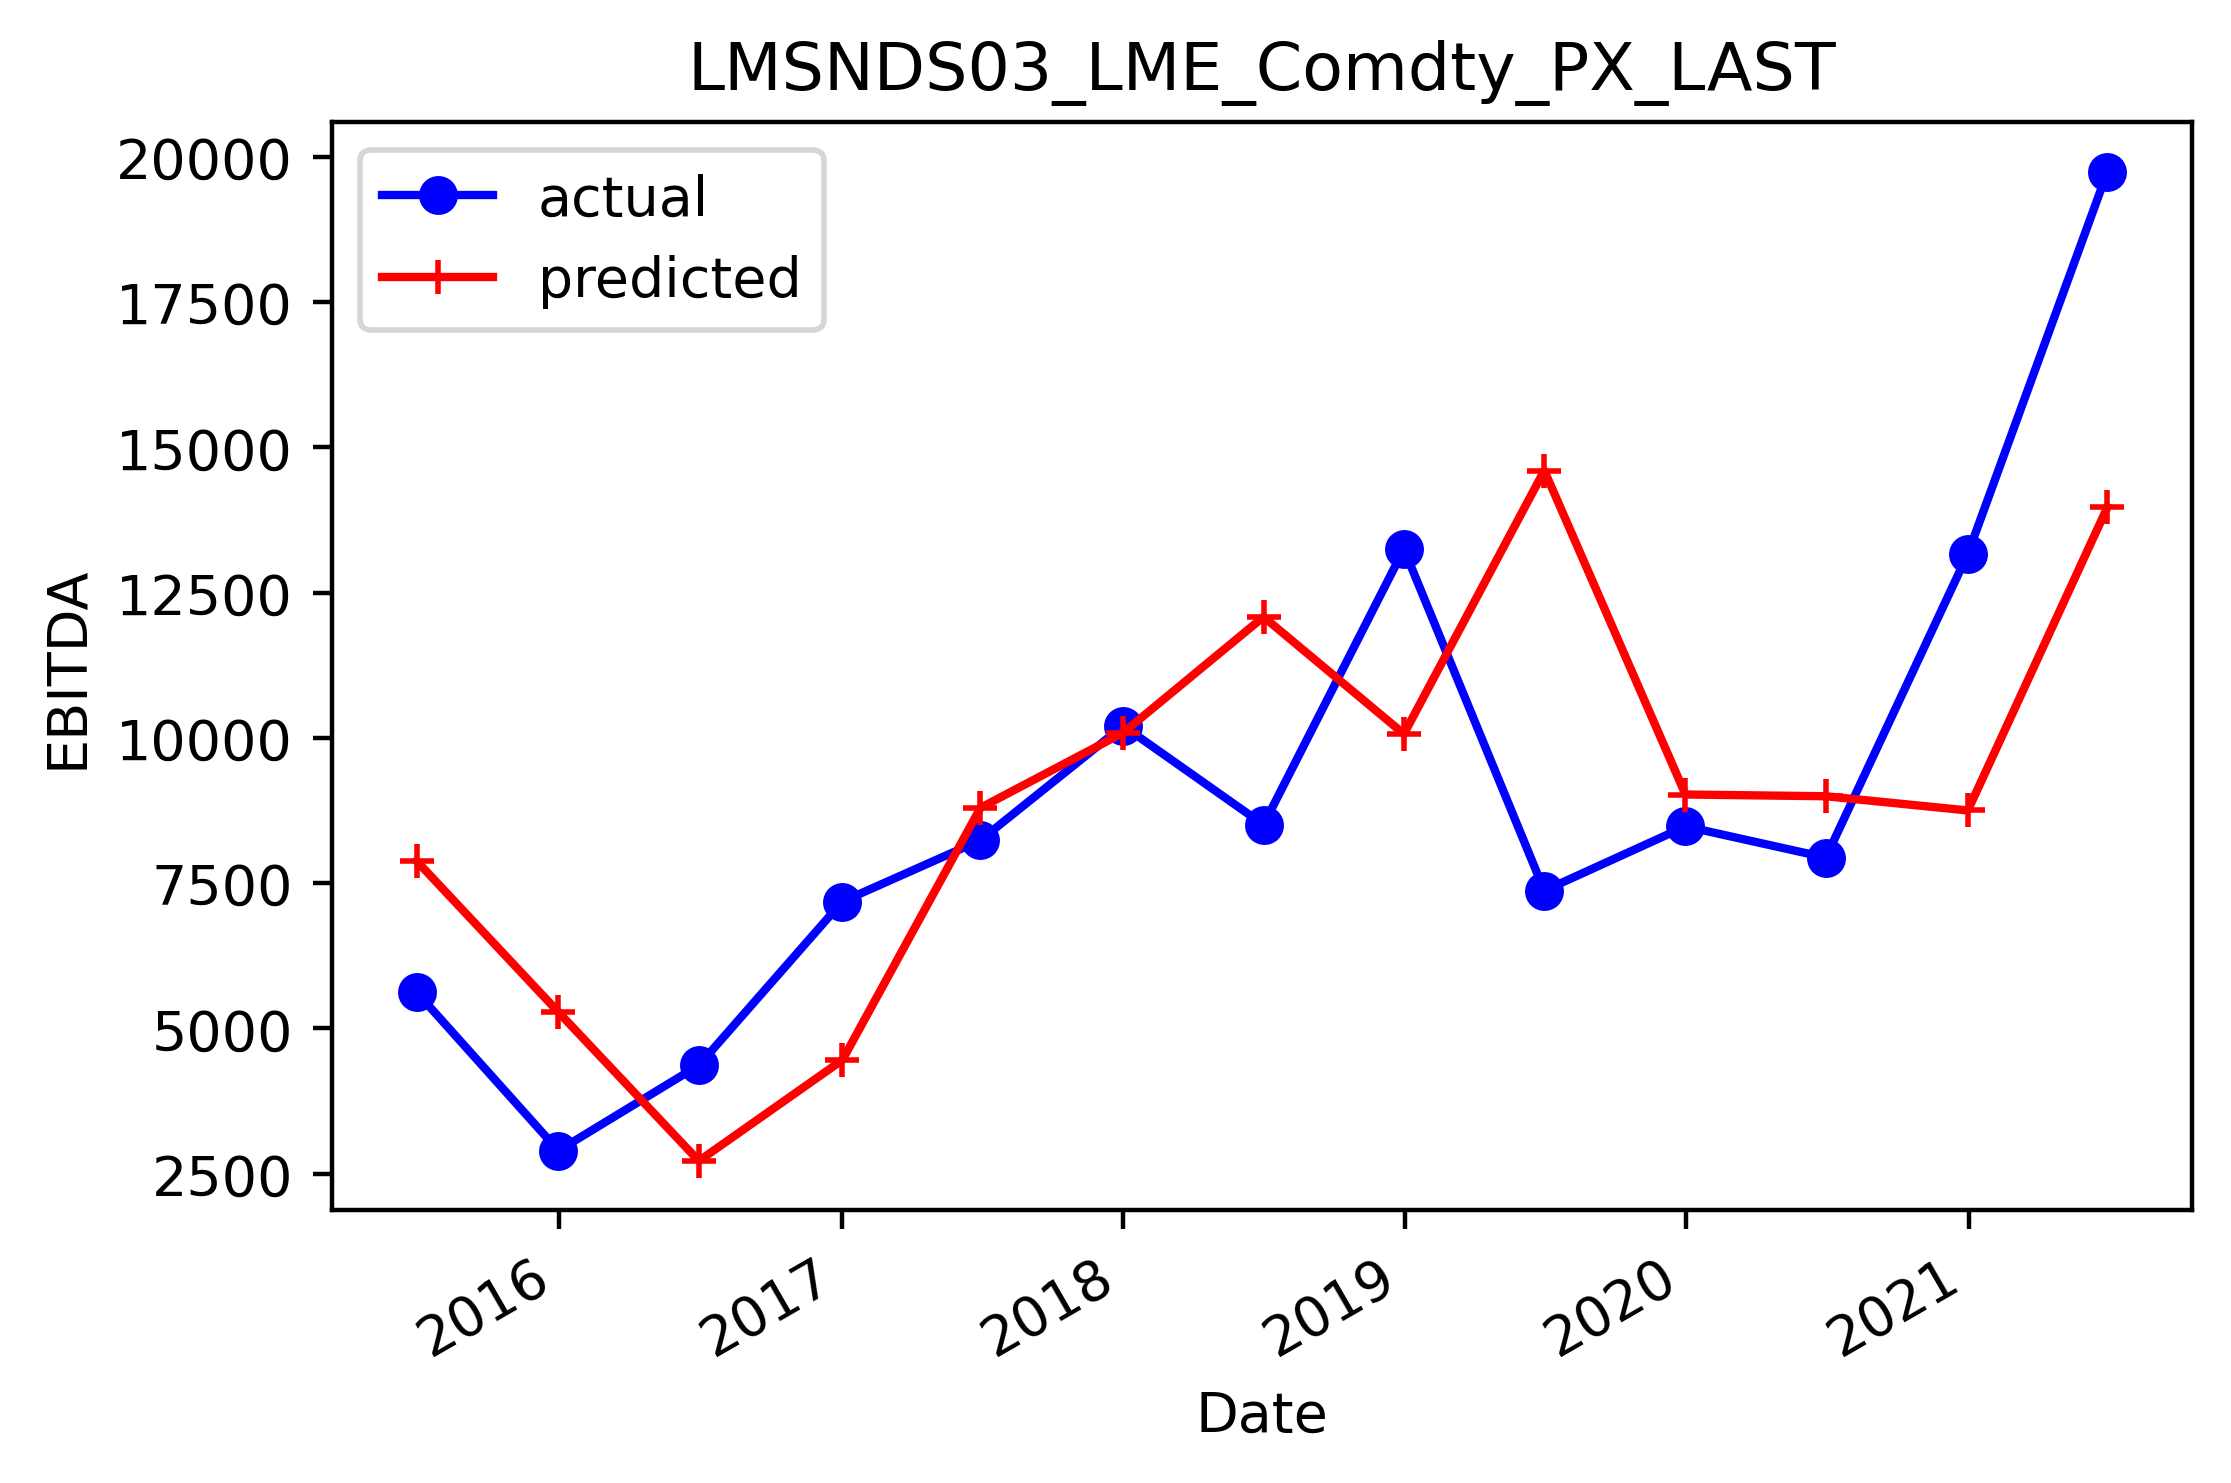

In [25]:
_, _ = models[3].predict_close_prices_for_days(13, with_plot=True)

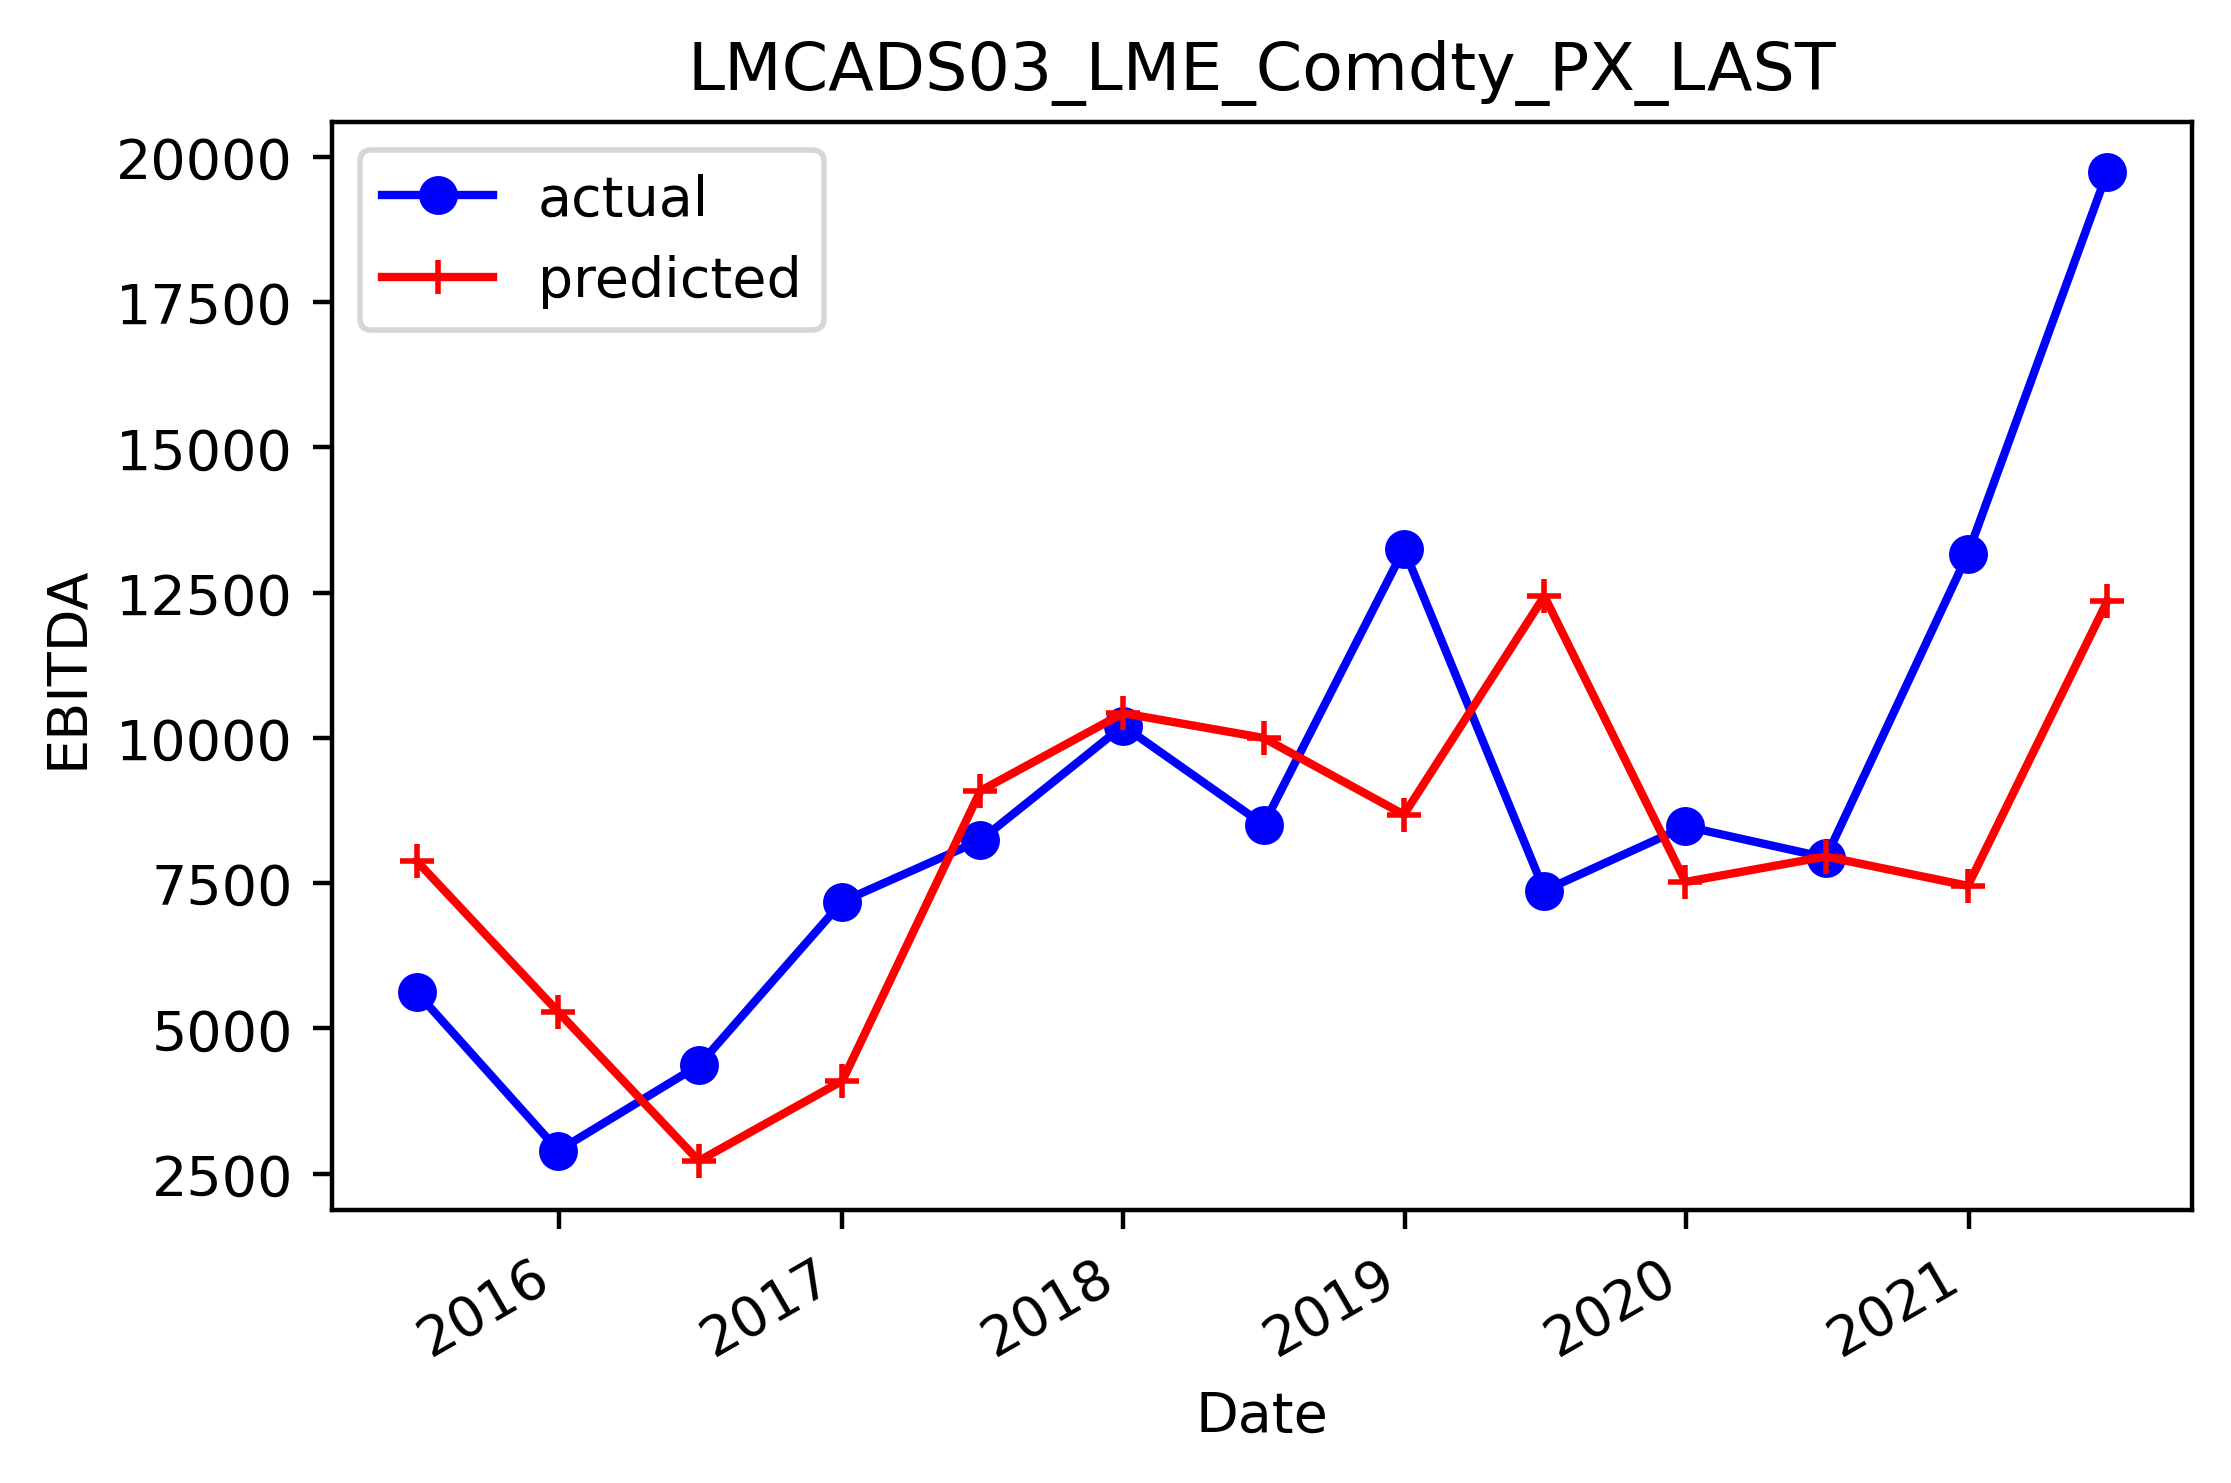

In [26]:
_, _ = models[4].predict_close_prices_for_days(13, with_plot=True)

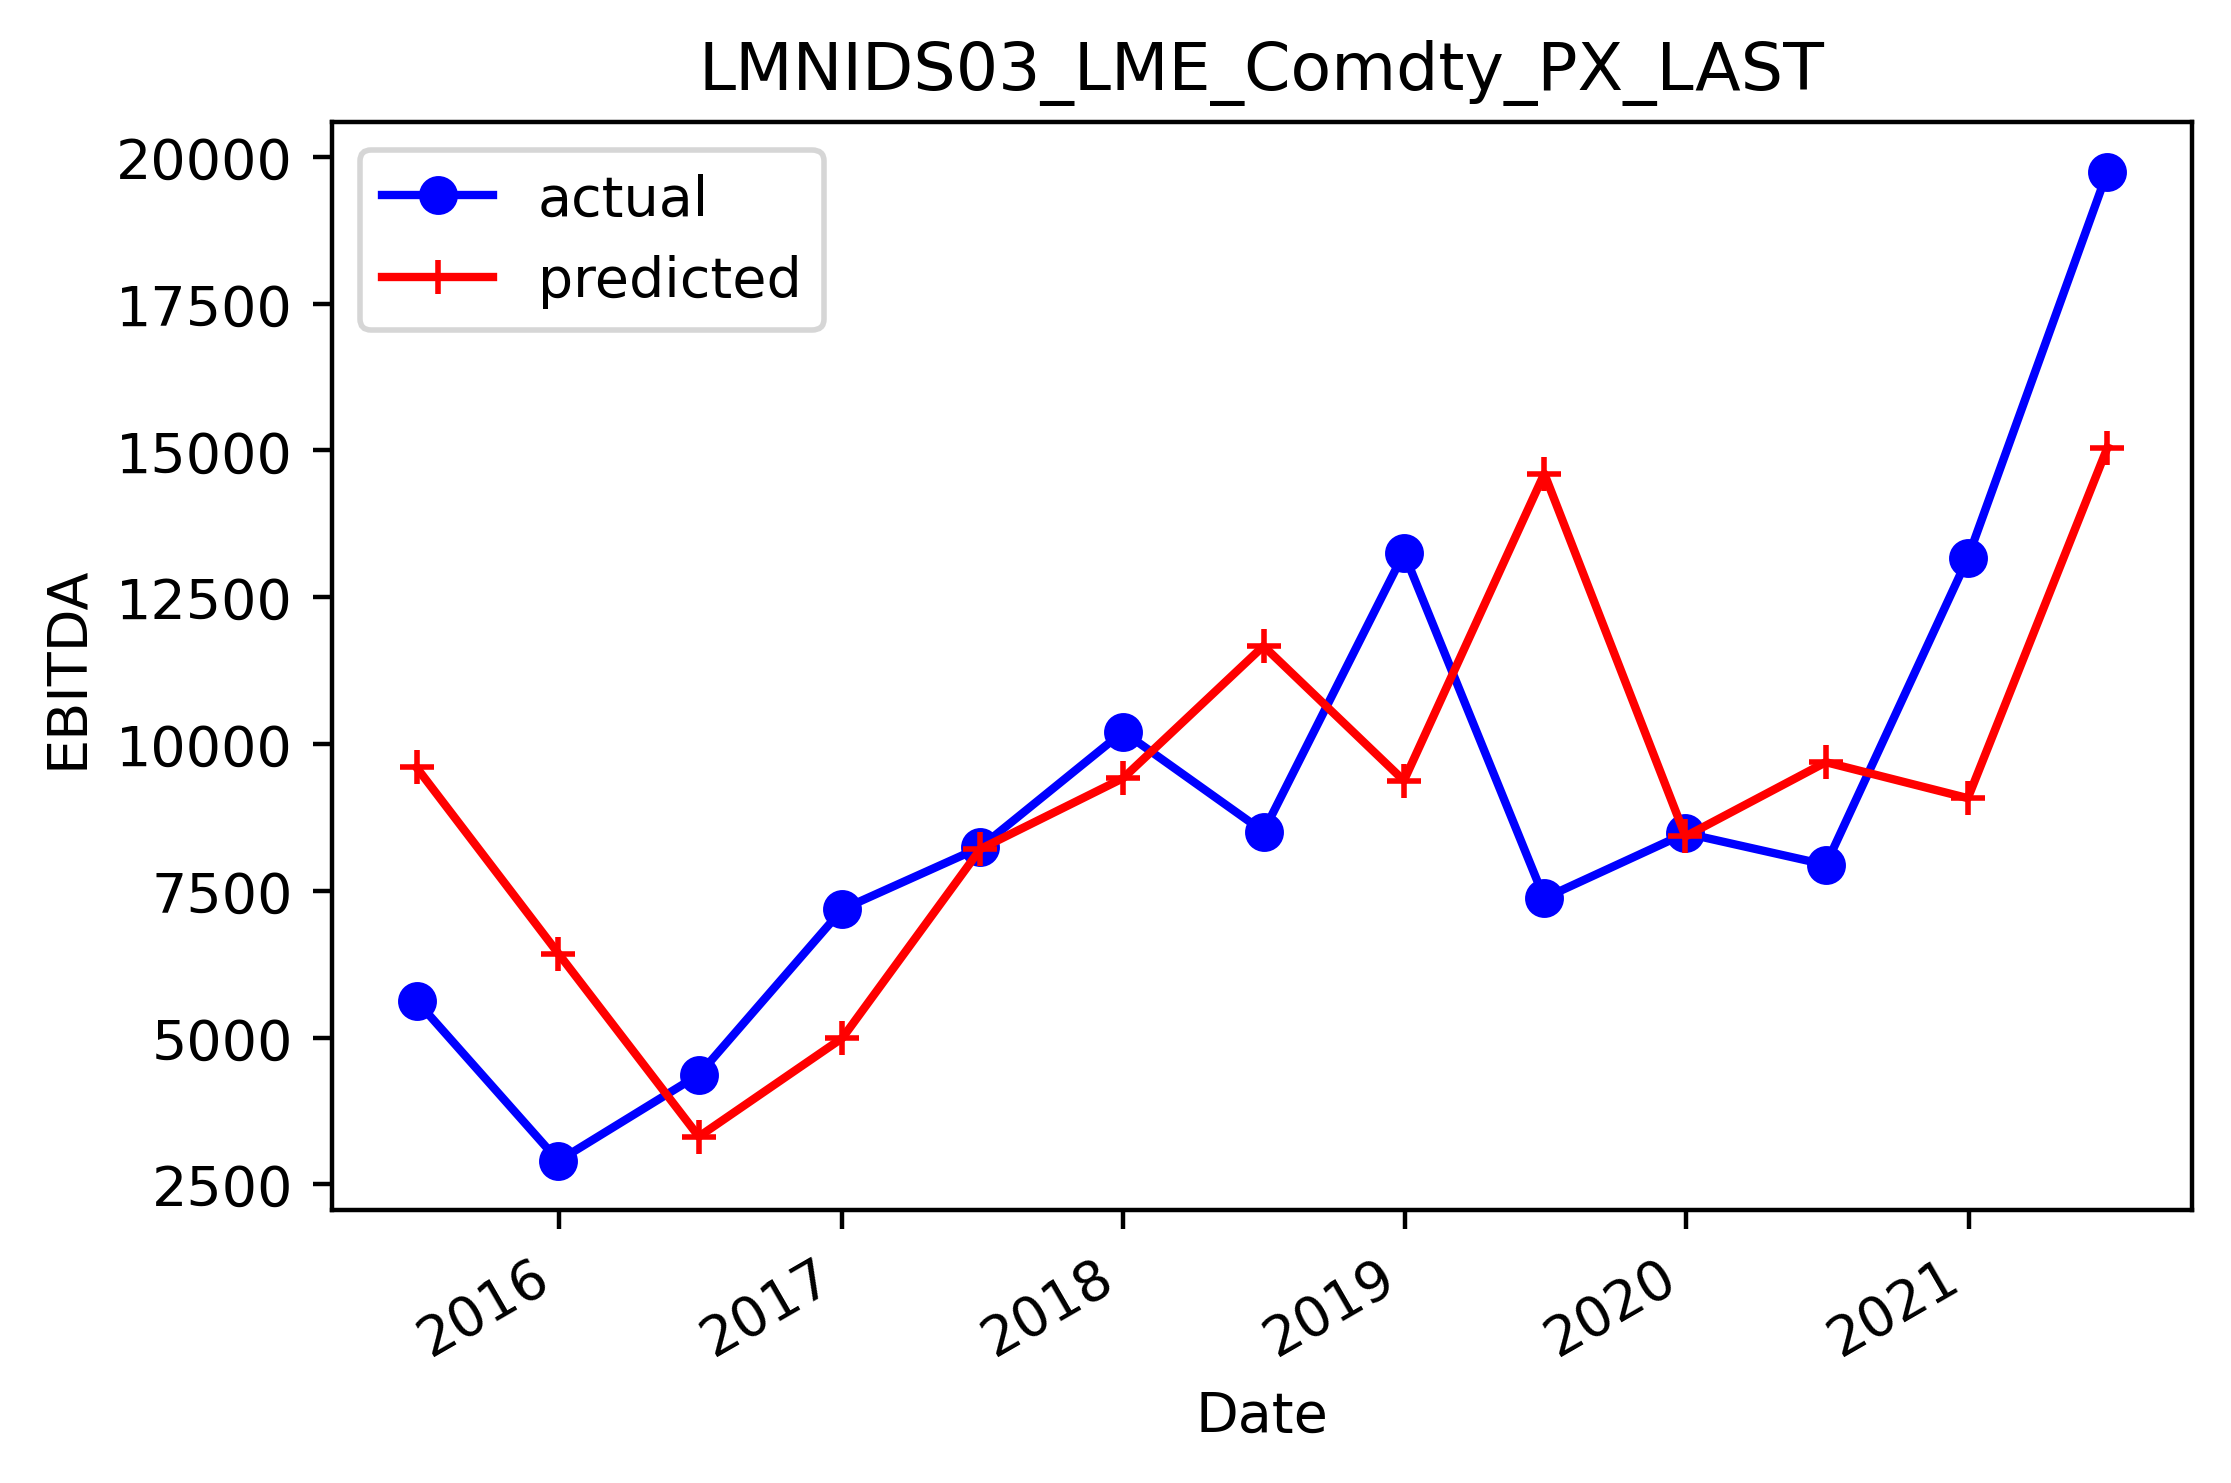

In [27]:
_, _ = models[5].predict_close_prices_for_days(13, with_plot=True)